In [125]:
import pandas as pd
import numpy as np
from tqdm import tqdm


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:.2f}'.format

In [59]:
df = pd.read_csv('/content/drive/Shareddrives/다빈치/SBK/Target.csv')
df.head()

,Unnamed: 0,cust,monetary,recency,frequency
0,0,M000034966,654120.0,9.0,12.0
1,1,M000059535,0.0,366.0,0.0
2,2,M000136117,27373630.0,2.0,70.0
3,3,M000201112,53120.0,34.0,5.0
4,4,M000225114,1937700.0,1.0,78.0


In [98]:
rfm_df = df.copy()

# 'Unnamed: 0' 열 제거
rfm_df = rfm_df.drop(['Unnamed: 0'], axis = 1)

# 구매 0번인 고객 제거
condition = rfm_df[rfm_df[['monetary', 'frequency']].sum(axis = 1) == 0].index
rfm_df = rfm_df.drop(condition)

rfm_df

,cust,monetary,recency,frequency
0,M000034966,654120.0,9.0,12.0
2,M000136117,27373630.0,2.0,70.0
3,M000201112,53120.0,34.0,5.0
4,M000225114,1937700.0,1.0,78.0
5,M000261625,6052700.0,28.0,48.0
...,...,...,...,...
29906,M999599111,1484022.0,48.0,8.0
29907,M999673157,2851370.0,14.0,17.0
29909,M999770689,1187140.0,1.0,122.0
29910,M999849895,1103792.0,31.0,34.0


In [99]:
# 등급별 점수 & 구간
grade = [1, 2, 3, 4]
m_cate = [10, 14423191, 61290790, 205294750]
f_cate = [0, 51, 132, 2712]
r_cate = [0, 41, 121, 229]

# RFM 열 생성
rfm_df['R'] = 0
rfm_df['F'] = 0
rfm_df['M'] = 0

# R 구간별 점수화
rfm_df.loc[rfm_df['recency'] >= r_cate[0], 'R'] = grade[3]
rfm_df.loc[rfm_df['recency'] >= r_cate[1], 'R'] = grade[2]
rfm_df.loc[rfm_df['recency'] >= r_cate[2], 'R'] = grade[1]
rfm_df.loc[rfm_df['recency'] >= r_cate[3], 'R'] = grade[0]

# F 구간별 점수화
rfm_df.loc[rfm_df['frequency'] >= f_cate[0], 'F'] = grade[0]
rfm_df.loc[rfm_df['frequency'] >= f_cate[1], 'F'] = grade[1]
rfm_df.loc[rfm_df['frequency'] >= f_cate[2], 'F'] = grade[2]
rfm_df.loc[rfm_df['frequency'] >= f_cate[3], 'F'] = grade[3]

# M 구간별 점수화
rfm_df.loc[rfm_df['monetary'] >= m_cate[0], 'M'] = grade[0]
rfm_df.loc[rfm_df['monetary'] >= m_cate[1], 'M'] = grade[1]
rfm_df.loc[rfm_df['monetary'] >= m_cate[2], 'M'] = grade[2]
rfm_df.loc[rfm_df['monetary'] >= m_cate[3], 'M'] = grade[3]

rfm_df

,cust,monetary,recency,frequency,R,F,M
0,M000034966,654120.0,9.0,12.0,4,1,1
2,M000136117,27373630.0,2.0,70.0,4,2,2
3,M000201112,53120.0,34.0,5.0,4,1,1
4,M000225114,1937700.0,1.0,78.0,4,2,1
5,M000261625,6052700.0,28.0,48.0,4,1,1
...,...,...,...,...,...,...,...
29906,M999599111,1484022.0,48.0,8.0,3,1,1
29907,M999673157,2851370.0,14.0,17.0,4,1,1
29909,M999770689,1187140.0,1.0,122.0,4,2,1
29910,M999849895,1103792.0,31.0,34.0,4,1,1


In [80]:
# def get_score(level, data, reverse = False):
#     '''
#     Description :
#     level안에 있는 원소를 기준으로
#     1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
#     Parameters :
#     level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
#     예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
#     data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
#     reverse = 점수가 높을 때 그에 해당하는 값을 낮게 설정하고 싶을 때 True
#     return :
#     점수를 담고 있는 리스트 반환
#     '''
#     score = [] 
#     for j in range(len(data)): 
#         for i in range(len(level)): 
#             if data[j] <= level[i]: 
#                 score.append(i+1) 
#                 break 
#             elif data[j] > max(level): 
#                 score.append(len(level)+1) 
#                 break 
#             else: 
#                 continue
#     if reverse:
#         return [len(level)+2-x for x in score]
#     else:
#         return score 
 
# grid_number = 100 ## 눈금 개수, 너무 크게 잡으면 메모리 문제가 발생할 수 있음.
# weights = []
# for j in range(grid_number+1):
#     weights += [(i/grid_number,j/grid_number,(grid_number-i-j)/grid_number)
#                   for i in range(grid_number+1-j)]

# num_class = 4 ## 클래스 개수
# class_level = np.linspace(1,4,num_class+1)[1:-1] ## 클래스를 나누는 지점을 정한다.
# total_amount_of_sales = rfm_df['monetary'].sum() ## 구매금액 총합 = 총 매출
# print(class_level)



In [81]:
# max_std = 0 ## 표준편차 초기값
# for w in tqdm(weights,position=0,desc = '[Finding Optimal weights]'):
#     ## 주어진 가중치에 따른 고객별 점수 계산
#     score = w[0]*rfm_df['R'] + w[1]*rfm_df['F'] + w[2]*rfm_df['M'] 
#     rfm_df['class'] = get_score(class_level,score,True) ## 점수를 이용하여 고객별 등급 부여
#     ## 등급별로 구매금액을 집계한다.
#     grouped_rfm_df = rfm_df.groupby('class')['monetary'].sum().reset_index()

#     ## 제약조건 추가 - 등급이 높은 고객들의 매출이 낮은 등급의 고객들보다 커야한다.
#     grouped_rfm_df = grouped_rfm_df.sort_values('class')
    
#     temp_monetary = list(grouped_rfm_df['monetary'])
#     if temp_monetary != sorted(temp_monetary,reverse=True):
#         continue

#     ## 클래스별 구매금액을 총구매금액으로 나누어 클래스별 매출 기여도 계산
#     grouped_rfm_df['monetary'] = grouped_rfm_df['monetary'].map(lambda x : x/total_amount_of_sales)
#     std_sales = grouped_rfm_df['monetary'].std() ## 매출 기여도의 표준편차 계산
#     if max_std <= std_sales:
#         max_std = std_sales ## 표준편차 최대값 업데이트
#         optimal_weights = w  ## 가중치 업데이트

# print(optimal_weights)

In [100]:
mms = MinMaxScaler()

rfm_data_cluster = rfm_df[['recency', 'frequency', 'monetary']]

rfm_data_scaled = mms.fit_transform(rfm_data_cluster)
rfm_data_scaled = pd.DataFrame(rfm_data_scaled, columns=['recency', 'frequency', 'monetary'])    
rfm_data_scaled.head()

,recency,frequency,monetary
0,0.021978,0.003635,0.001692
1,0.002747,0.022802,0.070809
2,0.090659,0.001322,0.000137
3,0.000000,0.025446,0.005012
4,0.074176,0.015532,0.015657


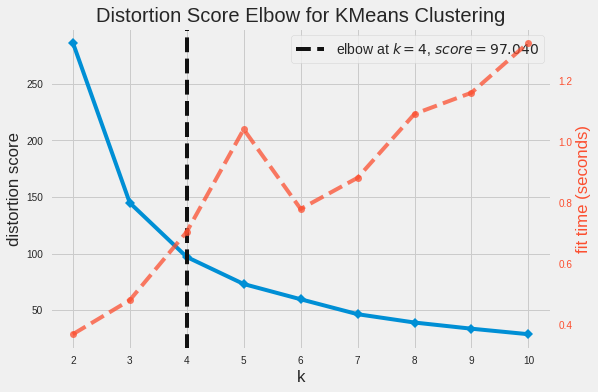

In [101]:
# finding best K using elbow method
# elbow 방식을 이용하여 최적의 K를 탐색합니다.
# KElbowVisualizer 알고리즘을 통해 확인 가능하고, K=4일때가 최적임을 알 수 있습니다.

km = KMeans()
elbow = KElbowVisualizer(estimator = km, k = 10)
elbow.fit(rfm_data_scaled)
elbow.show()

plt.show()

In [103]:
km = KMeans(n_clusters = 4, random_state = 42)
clusters = km.fit_predict(rfm_data_scaled)

rfm_data_scaled['cluster'] = clusters
rfm_data_scaled

,recency,frequency,monetary,cluster
0,0.021978,0.003635,0.001692,0
1,0.002747,0.022802,0.070809,0
2,0.090659,0.001322,0.000137,0
3,0.000000,0.025446,0.005012,0
4,0.074176,0.015532,0.015657,0
...,...,...,...,...
26912,0.129121,0.002313,0.003839,1
26913,0.035714,0.005288,0.007376,0
26914,0.000000,0.039987,0.003071,0
26915,0.082418,0.010905,0.002855,0


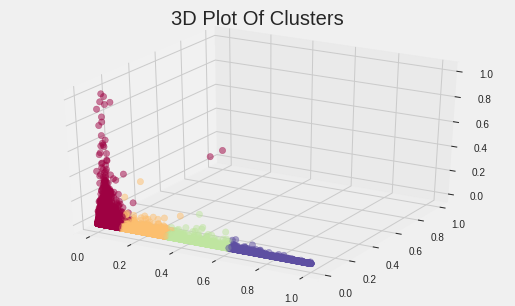

In [104]:
x = rfm_data_scaled['recency']
y = rfm_data_scaled['frequency']
z = rfm_data_scaled['monetary']

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection = '3d')
ax.scatter(x, y, z, s = 40, c = rfm_data_scaled['cluster'], marker = 'o', alpha = 0.5, cmap = 'Spectral')
ax.set_title("3D Plot Of Clusters")
plt.show()

In [105]:
rfm_df['cluster'] = rfm_data_scaled['cluster']
rfm_df['cluster'].value_counts().sort_index()

0.0    16995
1.0     4007
2.0     1823
3.0     1409
Name: cluster, dtype: int64

In [106]:
tmp = rfm_df.pivot_table(index = 'cluster', values=['recency', 'frequency', 'monetary'], aggfunc=['mean', 'std'])
tmp

mean                                 std                \
         frequency      monetary    recency  frequency      monetary   
cluster                                                                
0.0      47.098323  3.774822e+06  48.587938  55.387865  1.158724e+07   
1.0      47.537060  3.881505e+06  47.896431  51.774059  1.268731e+07   
2.0      45.816786  3.786700e+06  49.876029  51.058364  1.096688e+07   
3.0      46.760823  3.750620e+06  46.721079  49.974968  1.330923e+07   

                    
           recency  
cluster             
0.0      76.496970  
1.0      75.675932  
2.0      75.725659  
3.0      72.027631

In [107]:
# Recency = w1

cv_r_0 = tmp[('std', 'recency')][0] / tmp[('mean', 'recency')][0]
cv_r_1 = tmp[('std', 'recency')][1] / tmp[('mean', 'recency')][1]
cv_r_2 = tmp[('std', 'recency')][2] / tmp[('mean', 'recency')][2]
cv_r_3 = tmp[('std', 'recency')][3] / tmp[('mean', 'recency')][3]

w_r = np.min([cv_r_0, cv_r_1, cv_r_2, cv_r_3]) / np.sum([cv_r_0, cv_r_1, cv_r_2, cv_r_3])
w_r

0.24431907771377684

In [108]:
# Frequency = w2

cv_f_0 = tmp[('std', 'frequency')][0] / tmp[('mean', 'frequency')][0]
cv_f_1 = tmp[('std', 'frequency')][1] / tmp[('mean', 'frequency')][1]
cv_f_2 = tmp[('std', 'frequency')][2] / tmp[('mean', 'frequency')][2]
cv_f_3 = tmp[('std', 'frequency')][3] / tmp[('mean', 'frequency')][3]

w_f = np.min([cv_f_0, cv_f_1, cv_f_2, cv_f_3]) / np.sum([cv_f_0, cv_f_1, cv_f_2, cv_f_3])
w_f

0.24025852820401722

In [109]:
# Monetary = w3

cv_m_0 = tmp[('std', 'monetary')][0] / tmp[('mean', 'monetary')][0]
cv_m_1 = tmp[('std', 'monetary')][1] / tmp[('mean', 'monetary')][1]
cv_m_2 = tmp[('std', 'monetary')][2] / tmp[('mean', 'monetary')][2]
cv_m_3 = tmp[('std', 'monetary')][3] / tmp[('mean', 'monetary')][3]

w_m = np.min([cv_m_0, cv_m_1, cv_m_2, cv_m_3]) / np.sum([cv_m_0, cv_m_1, cv_m_2, cv_m_3])
w_m

0.22656379257698714

In [110]:
# 모든 가중치의 합을 1로 만들도록 변환하여 최종적으로 각 R, F, M에 대한 가중치를 구하였습니다.

W_R = w_r / (w_r + w_f + w_m)
W_F = w_f / (w_r + w_f + w_m)
W_M = w_m / (w_r + w_f + w_m)

print(f'Weight of Recency  : {W_R}')
print(f'Weight of Frequency: {W_F}')
print(f'Weight of Monetary : {W_M}')
print(f'Total sum of weight: {np.sum([W_R, W_F, W_M])}')

Weight of Recency  : 0.34355907029306465
Weight of Frequency: 0.33784916573912604
Weight of Monetary : 0.3185917639678093
Total sum of weight: 1.0


In [113]:
rfm_df['RFM_score'] = (rfm_df['R'].astype('int64') * W_R / 4 * 100 + rfm_df['F'].astype('int64') * W_F / 4 * 100 + rfm_df['M'].astype('int64') * W_M / 4 * 100)
rfm_df.head()

,cust,monetary,recency,frequency,R,F,M,cluster,RFM_score
0,M000034966,654120.0,9.0,12.0,4,1,1,0.0,50.766930
2,M000136117,27373630.0,2.0,70.0,4,2,2,0.0,67.177954
3,M000201112,53120.0,34.0,5.0,4,1,1,0.0,50.766930
4,M000225114,1937700.0,1.0,78.0,4,2,1,0.0,59.213159
5,M000261625,6052700.0,28.0,48.0,4,1,1,0.0,50.766930


In [114]:
rfm_df.RFM_score.describe()

count    26917.000000
mean        50.220829
std         10.937205
min         25.000000
25%         42.177954
50%         50.766930
75%         59.213159
max         91.553771
Name: RFM_score, dtype: float64

In [115]:
rfm_df.pivot_table(index = 'RFM_score', values=['recency', 'frequency', 'monetary'], aggfunc=['mean', 'count'])

mean                               count                 
             frequency      monetary     recency frequency monetary recency
RFM_score                                                                  
25.000000     4.229370  3.702054e+05  286.823912      1539     1539    1539
32.964794    28.000000  2.512626e+07  252.000000         2        2       2
33.446229    77.266667  2.423113e+06  250.533333        15       15      15
33.588977     9.363448  6.468276e+05  170.342679      1926     1926    1926
41.411023    61.000000  2.163727e+07  230.000000         1        1       1
41.553771    36.444444  2.665786e+07  186.777778         9        9       9
42.035206    75.306818  3.252319e+06  162.715909        88       88      88
42.177954    16.331618  1.179727e+06   71.034559      4080     4080    4080
50.000000    86.555556  2.062826e+07  169.333333         9        9       9
50.142748    25.428571  2.575455e+07   69.685714        35       35      35
50.481435   171.111111  6.297798e+06  164.777778         9        9       9
50.624183    73.520979  3.777032e+06   66.349650       286      286     286
50.766930    26.212948  1.675570e+06   13.458128     10735    10735   10735
58.107542    34.000000  9.831629e+07   49.000000         1        1       1
58.446229   184.000000  3.168781e+07  210.000000         1        1       1
58.588977    80.733333  2.581008e+07   66.533333        15       15      15
58.731724    35.397260  2.454051e+07   13.636986       146      146     146
59.070412   199.974359  5.724366e+06   73.358974        39       39      39
59.213159    79.487744  3.889956e+06    7.576668      5589     5589    5589
66.411023   180.000000  7.290125e+07  166.000000         1        1       1
66.553771    58.000000  6.129079e+07   43.000000         1        1       1
66.696518    33.111111  9.443621e+07   16.888889         9        9       9
67.035206   175.000000  2.533862e+07   65.200000         5        5       5
67.177954    92.347480  2.603348e+07    8.366048       377      377     377
67.659389   178.087077  6.170738e+06    3.798203      1447     1447    1447
75.000000   246.000000  1.362475e+08   61.000000         1        1       1
75.142748    95.325000  9.208689e+07    9.200000        40       40      40
75.624183   193.861650  2.794849e+07    4.322816       412      412     412
83.107542   107.750000  2.908919e+08    7.000000         4        4       4
83.588977   205.544304  9.723973e+07    4.202532        79       79      79
84.070412  2869.500000  3.588630e+07    1.000000         2        2       2
91.553771   188.642857  2.904584e+08    5.000000        14       14      14

In [116]:
rfm_df['class'] = pd.qcut(rfm_df.RFM_score, 4, labels = [4, 3, 2, 1]).astype(str)
rfm_df.head(10)

,cust,monetary,recency,frequency,R,F,M,cluster,RFM_score,class
0,M000034966,654120.0,9.0,12.0,4,1,1,0.0,50.766930,3
2,M000136117,27373630.0,2.0,70.0,4,2,2,0.0,67.177954,1
3,M000201112,53120.0,34.0,5.0,4,1,1,0.0,50.766930,3
4,M000225114,1937700.0,1.0,78.0,4,2,1,0.0,59.213159,2
5,M000261625,6052700.0,28.0,48.0,4,1,1,0.0,50.766930,3
6,M000350564,9630400.0,27.0,29.0,4,1,1,0.0,50.766930,3
7,M000419293,1833500.0,38.0,39.0,4,1,1,0.0,50.766930,3
8,M000494848,25624610.0,24.0,160.0,4,3,2,0.0,75.624183,1
9,M000504230,1414958.0,1.0,33.0,4,1,1,0.0,50.766930,3
10,M000508243,2581150.0,2.0,23.0,4,1,1,1.0,50.766930,3


In [140]:
rfm_df.to_csv('/content/drive/Shareddrives/다빈치/Jdy/labeling_result.csv')

In [118]:
rfm_df['class'].value_counts()

3    11074
4     7660
2     5791
1     2392
Name: class, dtype: int64

In [137]:
count = rfm_df.groupby('class')['cust'].size()
count_df = pd.DataFrame(count)
count_df.rename(columns = {'cust' : 'cust_count'}, inplace = True)

contribution = rfm_df.groupby('class')['monetary'].sum() / rfm_df['monetary'].sum()
contribution_df = pd.DataFrame(contribution)
contribution_df.rename(columns = {'monetary' : 'contribution'}, inplace = True)

result_df = pd.merge(count_df, contribution_df, how='left', left_on='class', right_on='class')
result_df

,cust_count,contribution
class,,
1,2392,0.47
2,5791,0.26
3,11074,0.20
4,7660,0.07


In [141]:
result_df.to_csv('/content/drive/Shareddrives/다빈치/Jdy/labeling_summary.csv')

In [117]:
from scipy import stats

In [120]:
cls1_r = rfm_df[rfm_df['class'] == '1']['recency']
cls2_r = rfm_df[rfm_df['class'] == '2']['recency']
cls3_r = rfm_df[rfm_df['class'] == '3']['recency']
cls4_r = rfm_df[rfm_df['class'] == '4']['recency']

stats.f_oneway(cls1_r, cls2_r, cls3_r, cls4_r)

F_onewayResult(statistic=12722.733861423043, pvalue=0.0)

In [121]:
cls1_f = rfm_df[rfm_df['class'] == '1']['frequency']
cls2_f = rfm_df[rfm_df['class'] == '2']['frequency']
cls3_f = rfm_df[rfm_df['class'] == '3']['frequency']
cls4_f = rfm_df[rfm_df['class'] == '4']['frequency']

stats.f_oneway(cls1_f, cls2_f, cls3_f, cls4_f)

F_onewayResult(statistic=16193.521449188518, pvalue=0.0)

In [122]:
cls1_m = rfm_df[rfm_df['class'] == '1']['monetary']
cls2_m = rfm_df[rfm_df['class'] == '2']['monetary']
cls3_m = rfm_df[rfm_df['class'] == '3']['monetary']
cls4_m = rfm_df[rfm_df['class'] == '4']['monetary']

stats.f_oneway(cls1_m, cls2_m, cls3_m, cls4_m)

F_onewayResult(statistic=2286.728288573008, pvalue=0.0)